# Stock Price Prediction using ANN

### importing libraries

In [1]:
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
from keras import models, layers
import yfinance as yf
import matplotlib.pyplot as plt

### Apple's Stock Data

In [2]:
# AAPL -- Apple's ticker
apple = yf.Ticker('AAPL')

### data frame

In [3]:
history = apple.history(period='max', interval='1d')

In [4]:
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.100266,0.100702,0.100266,0.100266,469033600,0.000,0.0
1980-12-15,0.095470,0.095470,0.095035,0.095035,175884800,0.000,0.0
1980-12-16,0.088495,0.088495,0.088059,0.088059,105728000,0.000,0.0
1980-12-17,0.090239,0.090675,0.090239,0.090239,86441600,0.000,0.0
1980-12-18,0.092855,0.093291,0.092855,0.092855,73449600,0.000,0.0
...,...,...,...,...,...,...,...
2020-11-02,108.922083,110.489379,107.135165,108.582664,122866900,0.000,0.0
2020-11-03,109.471139,111.297981,108.542740,110.249794,107624400,0.000,0.0
2020-11-04,113.943419,115.390919,112.156501,114.752022,138235500,0.000,0.0


### function that uses TimeseriesGenerator class to generate the training set with dividends info

In [5]:
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']
    tsg = TimeseriesGenerator(close, close,
                              length=value_num,
                              batch_size=len(close))
    global_index = value_num
    i, t = tsg[0]
    has_dividends = np.zeros(len(i))
    for b_row in range(len(t)):
        assert(abs(t[b_row] - close[global_index]) <= 0.001)
        has_dividends[b_row] = dividends[global_index] > 0            
        global_index += 1
    return np.concatenate((i, np.transpose([has_dividends])),
                           axis=1), t

In [6]:
inputs, targets = generate_series(history, 4)

### performing MinMax normalization

In [8]:
h_min = history.min()
normalized_h = (history - h_min) / (history.max() - h_min)

In [9]:
inputs, targets = generate_series(normalized_h, 4)

### creates a neural network with a specified number of inputs

In [11]:
def create_model(n):
    m = models.Sequential()
    m.add(layers.Dense(64, activation='relu', input_shape=(n+1,)))
    m.add(layers.Dense(64, activation='relu'))
    m.add(layers.Dense(1))
    return m

### splitting data into test and train

In [12]:
train_inputs = inputs[:-1000]
val_inputs = inputs[-1000:]
train_targets = targets[:-1000]
val_targets = targets[-1000:]

### training the model

In [13]:
def select_inputs(data, start, end, epochs):
    models = {}
    for inputs in range(start, end+1):
        print('Using {} inputs'.format(inputs))
        model_inputs, targets = generate_series(data, inputs)
        
        train_inputs = model_inputs[:-1000]
        val_inputs = model_inputs[-1000:]
        train_targets = targets[:-1000]
        val_targets = targets[-1000:]
        
        m = create_model(inputs)
        print('Training')
        m.compile(optimizer='adam', loss='mse') 
        h = m.fit(train_inputs, train_targets,
                  epochs=epochs,
                  batch_size=32,
                  validation_data=(val_inputs, val_targets))
        model_info = {'model': m, 'history': h.history}
        models[inputs] = model_info
    return models


In [14]:
trained_models = select_inputs(normalized_h, 2, 10, 20)

Using 2 inputs
Training
Epoch 1/20
284/284 [==============================] - 0s 1ms/step - loss: 8.7534e-05 - val_loss: 0.0055
Epoch 2/20
284/284 [==============================] - 0s 1ms/step - loss: 5.1700e-06 - val_loss: 0.0051
Epoch 3/20
284/284 [==============================] - 0s 889us/step - loss: 1.9065e-06 - val_loss: 0.0051
Epoch 4/20
284/284 [==============================] - 0s 910us/step - loss: 3.6403e-06 - val_loss: 0.0055
Epoch 5/20
284/284 [==============================] - 0s 871us/step - loss: 2.9702e-06 - val_loss: 0.0052
Epoch 6/20
284/284 [==============================] - 0s 852us/step - loss: 1.9016e-06 - val_loss: 0.0053
Epoch 7/20
284/284 [==============================] - 0s 884us/step - loss: 8.1460e-06 - val_loss: 0.0050
Epoch 8/20
284/284 [==============================] - 0s 1ms/step - loss: 3.1385e-05 - val_loss: 0.0027
Epoch 9/20
284/284 [==============================] - 0s 905us/step - loss: 1.7288e-06 - val_loss: 0.0025
Epoch 10/20
284/284 [=======

### short summary

In [15]:
model_stats = {}
for k, v in trained_models.items():
    train_history = v['history']
    loss = train_history['loss'][-1]
    val_loss = train_history['val_loss'][-1]
    model_stats[k] = {'inputs': k, 'loss': loss, 'val_loss': val_loss}

In [16]:
model_stats

{2: {'inputs': 2,
  'loss': 2.2065662506065564e-06,
  'val_loss': 0.00217586406506598},
 3: {'inputs': 3,
  'loss': 2.150989303117967e-06,
  'val_loss': 0.001493913703598082},
 4: {'inputs': 4,
  'loss': 5.852361937286332e-06,
  'val_loss': 0.0009642249206081033},
 5: {'inputs': 5,
  'loss': 2.094831188514945e-06,
  'val_loss': 0.00013151360326446593},
 6: {'inputs': 6,
  'loss': 3.0977651022112696e-06,
  'val_loss': 0.00016655816580168903},
 7: {'inputs': 7,
  'loss': 3.0348744530783733e-06,
  'val_loss': 0.00017243721231352538},
 8: {'inputs': 8,
  'loss': 2.3417665033775847e-06,
  'val_loss': 0.0002405862760497257},
 9: {'inputs': 9,
  'loss': 3.1595388918503886e-06,
  'val_loss': 0.0004101269587408751},
 10: {'inputs': 10,
  'loss': 2.4525334083591588e-06,
  'val_loss': 0.0004234199586790055}}

### plotting val loss

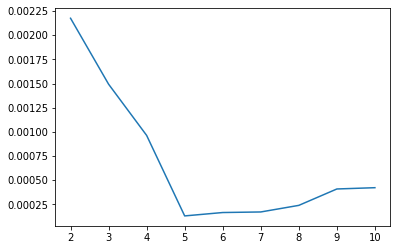

In [17]:
import matplotlib.pyplot as plt
val_loss = []
indices = []
for k, v in model_stats.items():
    indices.append(k)
    val_loss.append(v['val_loss'])
plt.plot(indices, val_loss)

### actual loss

In [19]:
close_min = history['Close'].min()
close_max = history['Close'].max()
for k in model_stats:
    e = ((close_max - close_min) * model_stats[k]['val_loss'] + close_min)
    print(k, e)

2 0.3297336890517797
3 0.23841335079335654
4 0.16748244208290727
5 0.05597362345312527
6 0.06066645959757583
7 0.061453725865669405
8 0.07057960350138001
9 0.09328288715181118
10 0.09506295989523827
